# Hierarchical Clustering
Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

**Bottom-up clustering** or **agglomerative clustering** treat each document as a singleton cluster and successively merge clusters until a single cluster containing all the documents has created.

Main steps:
- Compute N x N similarity matrix S
- Execute N - 1 steps in which the most similar clusters are merged and the corresponding rows and columns are updated with the similarity of the new merged cluster with all the other clusters 
- Store history of subsequent aggregations

There are different stategies for computing the similarity between clusters for the merging step:
- **single link** $\rightarrow$ $d(\mu, \omega) = \min(d(\mu_i, \omega_j))$
- **complete link** $\rightarrow$ $d(\mu, \omega) = \max(d(\mu_i, \omega_j))$
- **average link** $\rightarrow$ $d(\mu, \omega) = avg(d(\mu_i, \omega_j))$
- **centroid link** $\rightarrow$ $d(\mu, \omega) = \mid\mid \vec{\mu} - \vec{\omega} \mid\mid^2$
- **median link** $\rightarrow$ $d(\mu, \omega)$ = same as 'centroid', but the new centroid is the average of the two cluster centroids
- **ward link** $\rightarrow$ $d(\mu, \omega) = \frac{\mid \mu \mid \mid \omega \mid}{\mid \mu \mid + \mid \omega \mid} \mid\mid \vec{\mu} - \vec{\omega} \mid\mid^2$ this is a measure of how much the sum of squares will increase when we merge clusters.

Cluster selection from the dendogram:
- Cut the dendogram at a specific level of similarity
- Cut the dendogram where the gap between two successive combination similarities is largest
- $K = argmin_{k'} [RSS(k') + \lambda k']$ where $k'$ is the cut threshold that produces $k$ clusters
- Pre-define $K$ and cut the dendogram accordingly

## Init the MEC environment

In [16]:
from IPython.core.display import display, HTML
import nbimporter
import sklearn.cluster as cls
import numpy as np
from sklearn.decomposition import PCA

In [34]:
from sklearn.datasets.samples_generator import make_blobs

seeds = [[1, 0], [0, 1], [1, 1], [-1, -1], [-1, 0], [0, -1], [-1, 1], [1, -1]]
M, _ = make_blobs(n_samples=300, centers=seeds, cluster_std=0.3)

In [35]:
def visualize(matrix, axes, labels=None, p1=None, p2=None):
    if p1 is None: p1 = 0
    if p2 is None: p2 = 1
    pca = PCA(n_components=min([p2+1,matrix.shape[1]]))
    pca.fit(matrix)
    m = pca.transform(matrix)
    if labels is None:
        axes.scatter(m[:,[p1]], m[:,[p2]], alpha=0.4)
    else:
        axes.scatter(m[:,[p1]], m[:,[p2]], alpha=0.4, c=labels)

# Python SciPy implementation

In [36]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
import numpy as np

Z = linkage(M, 'ward')
print Z

[[  7.00000000e+01   2.58000000e+02   7.12411990e-03   2.00000000e+00]
 [  1.60000000e+01   2.02000000e+02   8.51234694e-03   2.00000000e+00]
 [  3.20000000e+01   2.50000000e+02   1.55465263e-02   2.00000000e+00]
 ..., 
 [  5.85000000e+02   5.92000000e+02   1.01778515e+01   1.15000000e+02]
 [  5.94000000e+02   5.95000000e+02   1.63490062e+01   1.85000000e+02]
 [  5.96000000e+02   5.97000000e+02   1.98725109e+01   3.00000000e+02]]


## Cophenetic correlation
The goal is to measure if a dendrogram preserves the pairwise distances between the original unmodeled data points.

Given:
- $d(i, j)$ as the distance between the ith and the jth points
- $t(i, j)$ the dendrogrammatic distance between the model points Ti and Tj. This distance is the height of the node at which these two points are first joined together (<a href="https://en.wikipedia.org/wiki/Cophenetic_correlation">see more</a>)
- $\overline{d}$ and $\overline{t}$ are the average of $d(i, j)$ and $t(i, j)$

$$
c = \frac{\sum\limits_{i<j}(d(i,j)-\overline{d})(t(i,j)-\overline{t})}
{\sqrt{[\sum\limits_{i<j} (d(i,j) - \overline{d})]^2[\sum\limits_{i<j} (t(i,j) - \overline{t})]^2}}
$$

In [37]:
from scipy.spatial.distance import pdist
import time

H, T = {}, {}
methods = ['single', 'complete', 'average', 'ward']
for method in methods:
    start = time.time()
    H[method] = linkage(M, method)
    T[method] = time.time() - start

for method, L in H.items():
    c, coph = cophenet(L, pdist(M))
    print method, c, T[method]

average 0.708869782089 0.00158500671387
single 0.373161011841 0.00068211555481
ward 0.702801651932 0.00170302391052
complete 0.695513719145 0.00181603431702


In [38]:
print H[method][0]

[  7.00000000e+01   2.58000000e+02   7.12411990e-03   2.00000000e+00]


The linkage matrix contains a row for each step of the algorithm. The structure of a step in the linkage matrix is:

$$\langle i, j, \sigma, \kappa \rangle$$

where:
- $\sigma$ is the distance observed between $i$ and $j$
- $\kappa$ is the number of objects clustered in the step
- $i$ if $i < \mid D \mid$, $i$ denotes an object in the dataset. Otherwise $i$ denotes the aggregation obtained at step $i - \mid D \mid$. The same for $j$.

## The dendogram

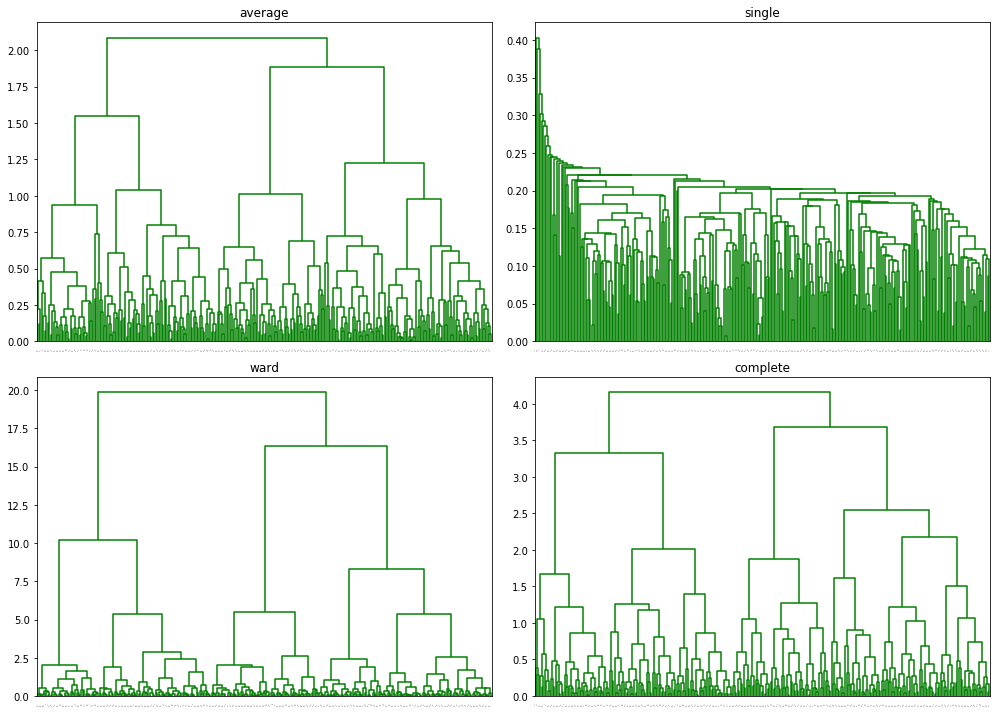

In [39]:
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 10))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    dendrogram(L,leaf_rotation=90.,leaf_font_size=0,ax=axes[cl/cols, cl%cols],
              color_threshold=100)
    cl += 1
plt.tight_layout()
plt.show()

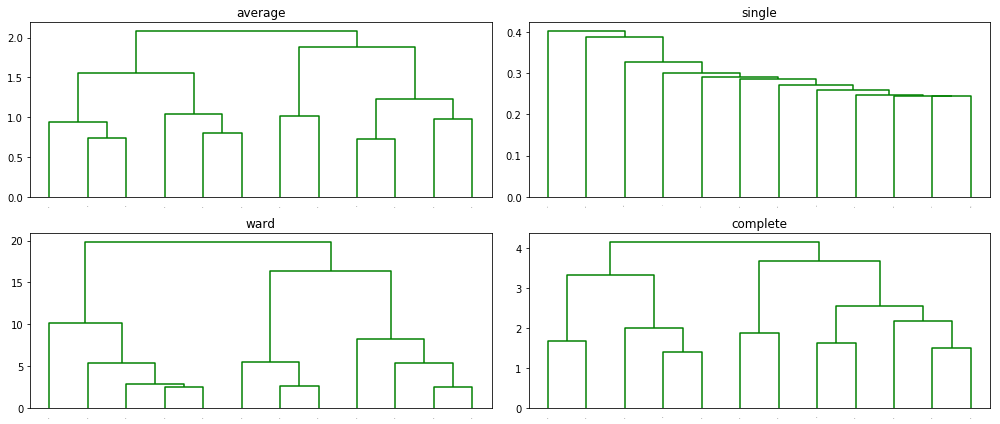

In [40]:
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 6))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    dendrogram(L,leaf_rotation=90.,leaf_font_size=0,ax=axes[cl/cols, cl%cols],
              truncate_mode='lastp', p=12, show_leaf_counts=True, color_threshold=100)
    cl += 1
plt.tight_layout()
plt.show()

## Setting the cut-off threshold
### Manual set-up

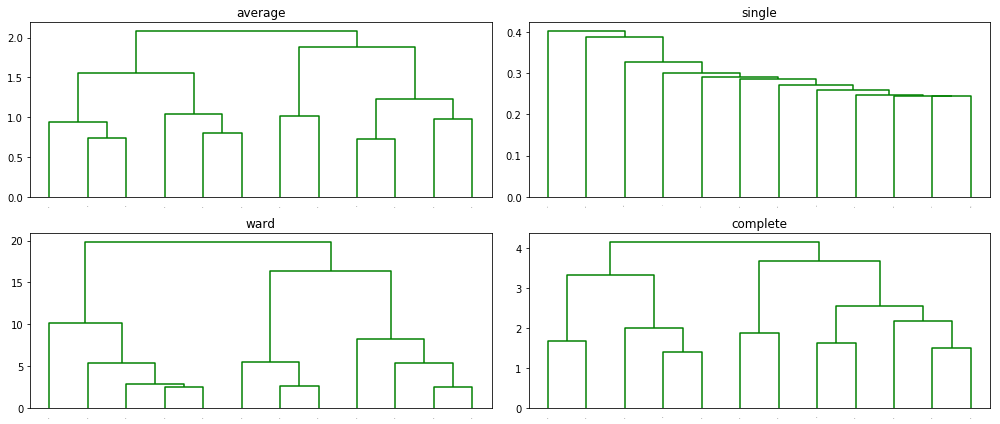

In [41]:
max_d = 40
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 6))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    dendrogram(L,leaf_rotation=90.,leaf_font_size=0,ax=axes[cl/cols, cl%cols],
              truncate_mode='lastp', p=12, show_leaf_counts=True, color_threshold=max_d)
    axes[cl/cols, cl%cols].axhline(y=max_d, c='k')
    cl += 1
plt.tight_layout()
plt.show()

### Authomatic approach
The scipy dendogram function automatically suggest a threshold for cut-off (colouring) which is 0.7*max(Z[:,2]).

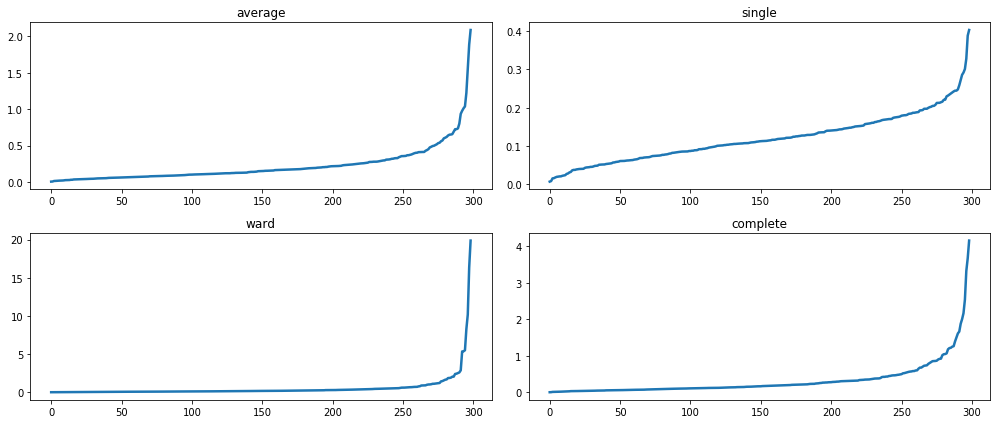

In [42]:
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 6))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    axes[cl/cols, cl%cols].plot(L[:,2], linewidth=2.5)
    cl += 1
plt.tight_layout()
plt.show()

### Inconsistency
Compare each cluster merge's height $h$ to the average $\mu$ and normalizing it by the standard deviation $\sigma$ formed over the depth previous levels.

Then, select descendants having an inconsistent value less than or equal to $t$ then all its leaf descendants belong to the same flat cluster. When no non-singleton cluster meets this criterion, every node is assigned to its own cluster.

In [43]:
from scipy.cluster.hierarchy import inconsistent, maxinconsts

depth = len(H['ward'])
incons = inconsistent(H['ward'], depth)
print incons #avg, std, count, inconsistency

[[  7.12411990e-03   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  8.51234694e-03   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.55465263e-02   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 ..., 
 [  4.76998113e-01   1.13842991e+00   1.14000000e+02   8.52125657e+00]
 [  5.18540265e-01   1.48542732e+00   1.84000000e+02   1.06571797e+01]
 [  5.67430450e-01   1.76115548e+00   2.99000000e+02   1.09615992e+01]]


### Distance
Observations in each flat cluster have no greater a cophenetic distance than $t$.

### Maxclust
Finds a minimum threshold $r$ so that the cophenetic distance between any two original observations in the same flat cluster is no more than $r$ and no more than $t$ flat clusters are formed.

### Elbow
Finds the clustering step where the acceleration of distance growth is the biggest (the *strongest elbow* of the blue line graph below).

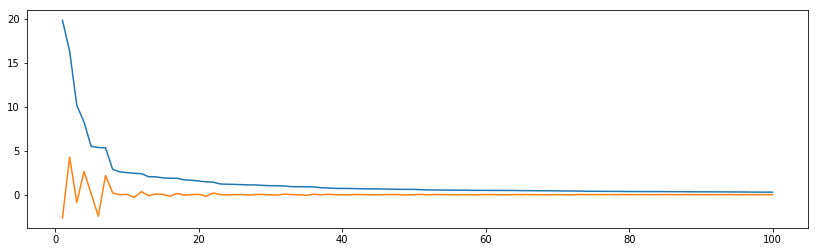

clusters: 1 16.3490061571


In [44]:
limits = 100
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
last = H['ward'][:, 2]
last_reverse = last[::-1]
idxs = np.arange(1, len(last) + 1)
axes.plot(idxs[:limits], last_reverse[:limits])

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_reverse = acceleration[::-1]
axes.plot(idxs[:limits], acceleration_reverse[:limits])
plt.show()
k = acceleration_reverse.argmax()  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k, last_reverse[k]

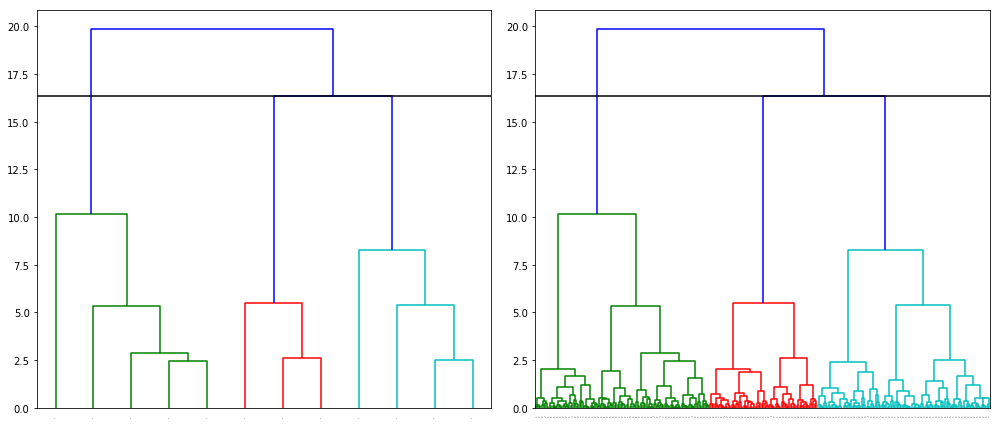

In [45]:
max_d = last_reverse[k]
cols = 2
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(14, 6))
dendrogram(H['ward'],leaf_rotation=90.,leaf_font_size=0,ax=axes[0],
          truncate_mode='lastp', p=12, show_leaf_counts=True, color_threshold=last_reverse[k])
axes[0].axhline(y=last_reverse[k], c='k')
dendrogram(H['ward'],leaf_rotation=90.,leaf_font_size=0,ax=axes[1],
          show_leaf_counts=True, color_threshold=last_reverse[k])
axes[1].axhline(y=last_reverse[k], c='k')
plt.tight_layout()
plt.show()

## Retrieve clusters

In [46]:
from scipy.cluster.hierarchy import fcluster

cl = H['ward']
max_d = last_reverse[k]

cl_distance = fcluster(cl, max_d, criterion='distance')
cl_k = fcluster(cl, k, criterion='maxclust')
cl_incons = fcluster(cl, 5, depth=10)

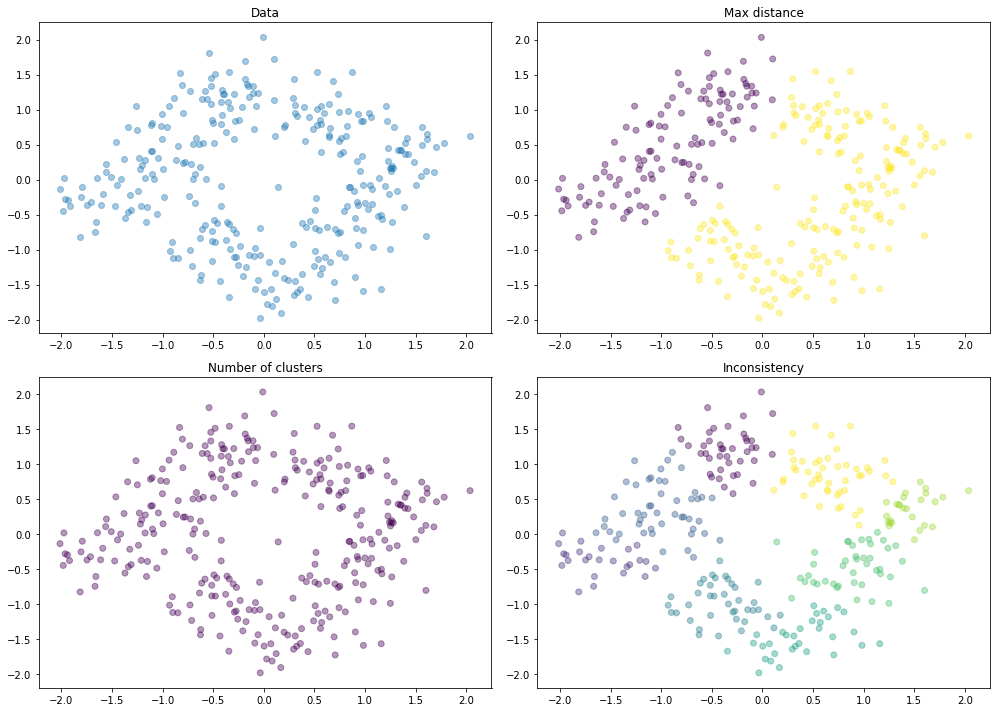

In [47]:
cut_offs = [None, cl_distance, cl_k, cl_incons]
titles = ['Data', 'Max distance', 'Number of clusters', 'Inconsistency']
cols = 2
rows = int(np.ceil(float(len(cut_offs))/cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 10))
for i, labels in enumerate(cut_offs):
    visualize(M, axes[i/cols,i%cols], labels=labels)
    axes[i/cols,i%cols].set_title(titles[i])
plt.tight_layout()
plt.show()